In [3]:
!pip install autogluon.multimodal

In [4]:
!pip install autogluon
!pip install torch torchvision torchaudio transformers

In [5]:
!pip uninstall torch torchaudio -y
!pip install torch torchvision torchaudio

Found existing installation: torch 2.3.1
Uninstalling torch-2.3.1:
  Successfully uninstalled torch-2.3.1
Found existing installation: torchaudio 2.3.1
Uninstalling torchaudio-2.3.1:
  Successfully uninstalled torchaudio-2.3.1
  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchaudio-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached triton-3.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.3 kB)
  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached torchaudio-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torchaudio-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
Using cached torc

In [6]:
!pip install autogluon --upgrade

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
import os
import warnings
from IPython.display import Image, display
import numpy as np
warnings.filterwarnings('ignore')
np.random.seed(123)

In [2]:
from autogluon.core.utils.loaders import load_pd
import pandas as pd
download_dir = './ag_automm_tutorial_imgtxt'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/flickr30k.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

In [3]:
dataset_path = os.path.join(download_dir, 'flickr30k_processed')
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
val_data = pd.read_csv(f'{dataset_path}/val.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
image_col = "image"
text_col = "caption"

In [4]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
val_data[image_col] = val_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

In [5]:
train_data.head()

,caption,image
0,Two young guys with shaggy hair look at their ...,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
1,Two young White males are outside near many bu...,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
2,Two men in green shirts are standing in a yard,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
3,A man in a blue shirt standing in a garden,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
4,Two friends enjoy time spent together,/content/ag_automm_tutorial_imgtxt/flickr30k_p...


In [6]:
train_data[text_col][0]

'Two young guys with shaggy hair look at their hands while hanging out in the yard'

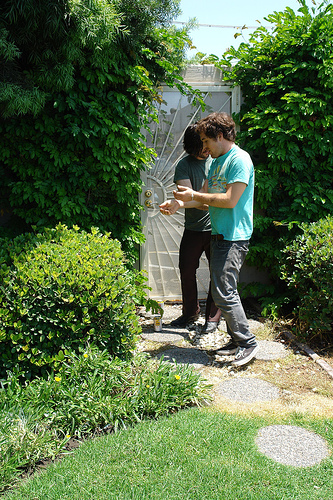

In [7]:
pil_img = Image(filename=train_data[image_col][0])
display(pil_img)

In [8]:
test_image_data = pd.DataFrame({image_col: test_data[image_col].unique().tolist()})
test_text_data = pd.DataFrame({text_col: test_data[text_col].unique().tolist()})
test_data_with_label = test_data.copy()
test_label_col = "relevance"
test_data_with_label[test_label_col] = [1] * len(test_data)

In [9]:
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor(
            query=text_col,
            response=image_col,
            problem_type="image_text_similarity",
            eval_metric="recall",
        )

In [10]:
txt_to_img_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_text_data,
            response_data=test_image_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
img_to_txt_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_image_data,
            response_data=test_text_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
print(f"txt_to_img_scores: {txt_to_img_scores}")
print(f"img_to_txt_scores: {img_to_txt_scores}")

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

txt_to_img_scores: {'recall@1': 0.58944, 'recall@5': 0.83513, 'recall@10': 0.90156}
img_to_txt_scores: {'recall@1': 0.15545, 'recall@5': 0.5712, 'recall@10': 0.7176}


In [ ]:
predictor.fit(
            train_data=train_data,
            tuning_data=val_data,
            time_limit=180,
        )

No path specified. Models will be saved in: "AutogluonModels/ag-20240915_021248"
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.3.1+cu121
CUDA Version:       CUDA is not available
Memory Avail:       9.28 GB / 12.67 GB (73.2%)
Disk Space Avail:   56.53 GB / 107.72 GB (52.5%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/AutogluonModels/ag-20240915_021248
    ```

INFO: Seed set to 0
GPU Count: 0
GPU Count to be Used: 0

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name              | Type                 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
txt_to_img_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_text_data,
            response_data=test_image_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
img_to_txt_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_image_data,
            response_data=test_text_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
print(f"txt_to_img_scores: {txt_to_img_scores}")
print(f"img_to_txt_scores: {img_to_txt_scores}")

In [ ]:
pred = predictor.predict(test_data.head(5))
print(pred)

In [ ]:
proba = predictor.predict_proba(test_data.head(5))
print(proba)

In [ ]:
image_embeddings = predictor.extract_embedding({image_col: test_image_data[image_col][:5].tolist()})
print(image_embeddings.shape)

In [ ]:
text_embeddings = predictor.extract_embedding({text_col: test_text_data[text_col][:5].tolist()})
print(text_embeddings.shape)

In [ ]:
from autogluon.multimodal.utils import semantic_search
text_to_image_hits = semantic_search(
        matcher=predictor,
        query_data=test_text_data.iloc[[3]],
        response_data=test_image_data,
        top_k=5,
    )

In [ ]:
test_text_data.iloc[[3]]

In [ ]:
pil_img = Image(filename=test_image_data[image_col][text_to_image_hits[0][0]['response_id']])
display(pil_img)

In [ ]:
image_to_text_hits = semantic_search(
        matcher=predictor,
        query_data=test_image_data.iloc[[6]],
        response_data=test_text_data,
        top_k=5,
    )

In [ ]:
pil_img = Image(filename=test_image_data[image_col][6])
display(pil_img)

In [ ]:
test_text_data[text_col][image_to_text_hits[0][1]['response_id']]